Netflix source:
* https://www.kaggle.com/datasets/victorsoeiro/netflix-tv-shows-and-movies?datasetId=2178661&sortBy=voteCount

Baby names sources: 
* https://www.kaggle.com/code/residentmario/regional-ethnic-baby-name-popularity-variations/data
* https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/TYJKEZ
* https://www.kaggle.com/datasets/fivethirtyeight/fivethirtyeight-most-common-name-dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_loc = 'data'

# EDA

## Titles

In [3]:
credits = pd.read_csv(f"{data_loc}/credits.csv")
titles = pd.read_csv(f"{data_loc}/titles.csv")
titles_og = titles.copy()

In [4]:
credits.head()

,person_id,id,name,character,role
0,3748,tm84618,Robert De Niro,Travis Bickle,ACTOR
1,14658,tm84618,Jodie Foster,Iris Steensma,ACTOR
2,7064,tm84618,Albert Brooks,Tom,ACTOR
3,3739,tm84618,Harvey Keitel,Matthew 'Sport' Higgins,ACTOR
4,48933,tm84618,Cybill Shepherd,Betsy,ACTOR


In [5]:
titles.head(1)

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,48,['documentation'],['US'],1.0,NaN,NaN,NaN,0.6,NaN


In [6]:
genres = titles[['id','genres']]

In [7]:
genres['genres'].apply(len).sort_values()

4131     2
1805     2
3129     2
3152     2
2998     2
        ..
423     86
717     89
371     93
3636    94
729     96
Name: genres, Length: 5806, dtype: int64

In [8]:
genres.iloc[729,:]

id                                                  ts20429
genres    ['scifi', 'action', 'animation', 'drama', 'wes...
Name: 729, dtype: object

In [9]:
def keep_only_abc(my_series):
    return my_series.str.replace('[^a-zA-Z]','')

In [10]:
def string_lists_to_lists(my_series):
    return my_series.str.replace('[^a-zA-Z0-9,]', '').str.split(',')

In [11]:
def series_lists_to_dummies(my_series, index):
    mlb = MultiLabelBinarizer()
    new_df = pd.DataFrame(mlb.fit_transform(my_series),columns=mlb.classes_, index=index).reset_index()
    if '' in new_df.columns:
        new_df = new_df.drop('', axis=1)
    return new_df

In [12]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

genres_dummies = series_lists_to_dummies(string_lists_to_lists(genres['genres']), genres.id)
countries_dummies = series_lists_to_dummies(string_lists_to_lists(titles['production_countries']), titles.id)

/var/folders/t9/ndly692n087cn_dhqldxy8s80000gn/T/ipykernel_6781/1394002080.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  return my_series.str.replace('[^a-zA-Z0-9,]', '').str.split(',')


In [13]:
titles_dummies = titles.merge(genres_dummies)
titles_dummies = titles_dummies.merge(countries_dummies)

In [14]:
titles_melt = titles.melt(id_vars=titles_og.columns)

## Cleaning

### Dataset: NYC

In [15]:
baby = pd.read_csv(f"{data_loc}/baby_names_nyc.csv")
baby.columns = ['yob', 'gender', 'ethnicity', 'first_name', 'count', 'rank']
baby.head(3)

,yob,gender,ethnicity,first_name,count,rank
0,2011,FEMALE,HISPANIC,GERALDINE,13,75
1,2011,FEMALE,HISPANIC,GIA,21,67
2,2011,FEMALE,HISPANIC,GIANNA,49,42


In [16]:
baby['first_name'] = baby['first_name'].str.lower()
baby['first_name'] = keep_only_abc(baby['first_name'])
baby.head(2)

/var/folders/t9/ndly692n087cn_dhqldxy8s80000gn/T/ipykernel_6781/1100466884.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  return my_series.str.replace('[^a-zA-Z]','')


,yob,gender,ethnicity,first_name,count,rank
0,2011,FEMALE,HISPANIC,geraldine,13,75
1,2011,FEMALE,HISPANIC,gia,21,67


In [17]:
credits['first_name'] = credits['name'].str.split(' ', expand=True)[0].str.lower()
credits['first_name'] = keep_only_abc(credits['first_name'])
credits.head(2)

/var/folders/t9/ndly692n087cn_dhqldxy8s80000gn/T/ipykernel_6781/1100466884.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  return my_series.str.replace('[^a-zA-Z]','')


,person_id,id,name,character,role,first_name
0,3748,tm84618,Robert De Niro,Travis Bickle,ACTOR,robert
1,14658,tm84618,Jodie Foster,Iris Steensma,ACTOR,jodie


In [18]:
baby_nodup = baby.sort_values(['first_name', 'rank']).drop_duplicates(subset='first_name')

In [19]:
credits = credits.merge(baby_nodup, how='left', on='first_name')

In [20]:
def rename_ethnicities(value: str) -> str:
    if type(value) != str:
        return value
    value = value.strip()
    if value == 'WHITE NON HISP':
        return 'WHITE NON HISPANIC'
    elif value == 'ASIAN AND PACI':
        return 'ASIAN AND PACIFIC ISLANDER'
    elif value == 'BLACK NON HISP':
        return 'BLACK NON HISPANIC'
    else:
        return value

In [21]:
# There were some weird ethinicity values that were cut off for some reason
credits['ethnicity'] = credits['ethnicity'].apply(rename_ethnicities)

In [22]:
credits['ethnicity'].value_counts()

ASIAN AND PACIFIC ISLANDER    10636
WHITE NON HISPANIC             9761
HISPANIC                       7151
BLACK NON HISPANIC             4000
Name: ethnicity, dtype: int64

In [23]:
credits.drop_duplicates(subset='first_name').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15263 entries, 0 to 77211
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   person_id   15263 non-null  int64  
 1   id          15263 non-null  object 
 2   name        15263 non-null  object 
 3   character   13278 non-null  object 
 4   role        15263 non-null  object 
 5   first_name  15263 non-null  object 
 6   yob         1220 non-null   float64
 7   gender      1220 non-null   object 
 8   ethnicity   1220 non-null   object 
 9   count       1220 non-null   float64
 10  rank        1220 non-null   float64
dtypes: float64(3), int64(1), object(7)
memory usage: 1.4+ MB


We got ethnicities for just 1220 names

### Dataset: Harvard Names

In [24]:
baby2 = pd.read_excel(f"{data_loc}/firstnames_harvard.xlsx",sheet_name=1)
baby2.head(3)

,firstname,obs,pcthispanic,pctwhite,pctblack,pctapi,pctaian,pct2prace
0,AARON,3646,2.88,91.607,3.264,2.057,0.055,0.137
1,ABBAS,59,0.00,71.186,3.390,25.424,0.000,0.000
2,ABBEY,57,0.00,96.491,3.509,0.000,0.000,0.000


In [25]:
baby2.columns

Index(['firstname', 'obs', 'pcthispanic', 'pctwhite', 'pctblack', 'pctapi',
       'pctaian', 'pct2prace'],
      dtype='object')

In [26]:
ethnicity_dict = {
    'pcthispanic':'HISPANIC',
    'pctwhite':'WHITE NON HISPANIC',
    'pctblack':'BLACK NON HISPANIC',
    'pctapi':'ASIAN AND PACIFIC ISLANDER',
    'pctaian':'ASIAN AND PACIFIC ISLANDER',
    'pct2prace':'MULTI ETHNIC'
}

In [27]:
baby2['ethnicity'] = baby2[['pcthispanic', 'pctwhite', 'pctblack', 
       'pctapi', 'pctaian',
       'pct2prace']].idxmax(axis=1)

In [28]:
baby2['ethnicity'] = baby2['ethnicity'].map(ethnicity_dict)

In [29]:
baby2['ethnicity'].unique()

array(['WHITE NON HISPANIC', 'ASIAN AND PACIFIC ISLANDER', 'HISPANIC',
       'BLACK NON HISPANIC'], dtype=object)

Mapping was successful, no NaNs

In [30]:
baby2['firstname'].drop_duplicates()

0                       AARON
1                       ABBAS
2                       ABBEY
3                       ABBIE
4                        ABBY
                ...          
4246                    ZOFIA
4247                    ZOILA
4248                   ZOLTAN
4249                    ZORAN
4250    ALL OTHER FIRST NAMES
Name: firstname, Length: 4251, dtype: object

In [31]:
len(baby2)

4251

No duplicates confirmed

In [32]:
baby2['first_name'] = keep_only_abc(baby2['firstname'].str.lower())

/var/folders/t9/ndly692n087cn_dhqldxy8s80000gn/T/ipykernel_6781/1100466884.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  return my_series.str.replace('[^a-zA-Z]','')


In [33]:
baby.merge(baby2, on='first_name',how='right').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19382 entries, 0 to 19381
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   yob          16059 non-null  float64
 1   gender       16059 non-null  object 
 2   ethnicity_x  16059 non-null  object 
 3   first_name   19382 non-null  object 
 4   count        16059 non-null  float64
 5   rank         16059 non-null  float64
 6   firstname    19382 non-null  object 
 7   obs          19382 non-null  int64  
 8   pcthispanic  19382 non-null  float64
 9   pctwhite     19382 non-null  float64
 10  pctblack     19382 non-null  float64
 11  pctapi       19382 non-null  float64
 12  pctaian      19382 non-null  float64
 13  pct2prace    19382 non-null  float64
 14  ethnicity_y  19382 non-null  object 
dtypes: float64(9), int64(1), object(5)
memory usage: 2.4+ MB


In [34]:
baby2

,firstname,obs,pcthispanic,pctwhite,pctblack,pctapi,pctaian,pct2prace,ethnicity,first_name
0,AARON,3646,2.880,91.607,3.264,2.057,0.055,0.137,WHITE NON HISPANIC,aaron
1,ABBAS,59,0.000,71.186,3.390,25.424,0.000,0.000,WHITE NON HISPANIC,abbas
2,ABBEY,57,0.000,96.491,3.509,0.000,0.000,0.000,WHITE NON HISPANIC,abbey
3,ABBIE,74,1.351,95.946,2.703,0.000,0.000,0.000,WHITE NON HISPANIC,abbie
4,ABBY,262,1.527,94.656,1.527,2.290,0.000,0.000,WHITE NON HISPANIC,abby
...,...,...,...,...,...,...,...,...,...,...
4246,ZOFIA,55,0.000,100.000,0.000,0.000,0.000,0.000,WHITE NON HISPANIC,zofia
4247,ZOILA,66,86.364,12.121,1.515,0.000,0.000,0.000,HISPANIC,zoila
4248,ZOLTAN,47,6.383,87.234,4.255,2.128,0.000,0.000,WHITE NON HISPANIC,zoltan
4249,ZORAN,52,0.000,100.000,0.000,0.000,0.000,0.000,WHITE NON HISPANIC,zoran


### Dataset: 538/Census

In [35]:
names = pd.read_csv(f"{data_loc}/538_most_common/new-top-firstNames.csv")

# NOTE: Unsure what "(S)" means, assumed to be NaN
surnames = pd.read_csv(f"{data_loc}/538_most_common/surnames.csv", na_values='(S)')

In [36]:
ethnicity_dict = {
    'pcthispanic':'HISPANIC',
    'pctwhite':'WHITE NON HISPANIC',
    'pctblack':'BLACK NON HISPANIC',
    'pctapi':'ASIAN AND PACIFIC ISLANDER',
    'pctaian':'ASIAN AND PACIFIC ISLANDER',
    'pct2prace':'MULTI ETHNIC'
}

In [37]:
pct_ethnic = [col for col in surnames.columns if 'pct' in col]
pct_ethnic

['pctwhite', 'pctblack', 'pctapi', 'pctaian', 'pct2prace', 'pcthispanic']

In [38]:
surnames['ethnicity'] = surnames[pct_ethnic].idxmax(axis=1)
surnames['ethnicity'] = surnames['ethnicity'].map(ethnicity_dict)

In [39]:
surnames['surname'] = keep_only_abc(surnames['name'].str.lower())
surnames.head(2)

/var/folders/t9/ndly692n087cn_dhqldxy8s80000gn/T/ipykernel_6781/1100466884.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  return my_series.str.replace('[^a-zA-Z]','')


,name,rank,count,prop100k,cum_prop100k,pctwhite,pctblack,pctapi,pctaian,pct2prace,pcthispanic,ethnicity,surname
0,SMITH,1,2376206,880.85,880.85,73.35,22.22,0.40,0.85,1.63,1.56,WHITE NON HISPANIC,smith
1,JOHNSON,2,1857160,688.44,1569.30,61.55,33.80,0.42,0.91,1.82,1.50,WHITE NON HISPANIC,johnson


## Dataset: all names

In [40]:
def calculate_num_names_left(dataset):
    '''
    Purely for informational purposes
    '''
    res = dataset.drop_duplicates(subset=['first_name', 'surname'], keep='first')['ethnicity'].isna()
    nans = res.sum()
    total = len(res)
    print(f"There are {nans} out of a total {total} non-duplicate names still without an assigned ethnicity")
    return None

In [41]:
def combine_ethnicity_columns(dataset):
    '''
    Combines all columns that contain ethnicity data into one column, giving
    preference in abc order of column name
    '''
    ethnicity_columns = [col for col in dataset.columns if 'ethnicity' in col]
    if 'ethnicity' in ethnicity_columns:
        ethnicity_columns.remove('ethnicity')
    # preference will be given to the alphabetically first col
    ethnicity_columns.sort()
    dataset['ethnicity'] = dataset[ethnicity_columns[0]].copy()
    for i in range(len(ethnicity_columns)):
        if i == len(ethnicity_columns)-1:
            # drop the extra columns that are no longer needed
            return dataset.drop(ethnicity_columns, axis=1)
        # first instance was copied, so this time it's skipped and filled with
        # the other sources
        dataset['ethnicity'] = dataset['ethnicity'].fillna(dataset[ethnicity_columns[i+1]])

In [42]:
combined = credits.merge(baby2[['first_name','ethnicity']], on='first_name', how='left')

In [43]:
last_names = combined['name'].str.split(' ', expand=True)[[1,2]]
combined['surname'] = last_names[2].fillna(last_names[1])
combined['surname'] = keep_only_abc(combined['surname'].str.lower())

/var/folders/t9/ndly692n087cn_dhqldxy8s80000gn/T/ipykernel_6781/1100466884.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  return my_series.str.replace('[^a-zA-Z]','')


In [44]:
combined = combined.merge(surnames[['surname','ethnicity']], on='surname', how='left')
# rename to give priority to census source over NYC/Harvard top 1k first names
combined['ethnicity_w'] = combined['ethnicity'] 

In [45]:
# merge columns and remove unneeded ones
combined = combine_ethnicity_columns(combined)

ethn_na = calculate_num_names_left(combined)

There are 7022 out of a total 53450 non-duplicate names still without an assigned ethnicity


In [46]:
combined.head(2)

,person_id,id,name,character,role,first_name,yob,gender,count,rank,surname,ethnicity
0,3748,tm84618,Robert De Niro,Travis Bickle,ACTOR,robert,2013.0,MALE,86.0,38.0,niro,WHITE NON HISPANIC
1,14658,tm84618,Jodie Foster,Iris Steensma,ACTOR,jodie,NaN,NaN,NaN,NaN,foster,WHITE NON HISPANIC


In [47]:
combined.groupby(['id','ethnicity']).count().sort_values('name').tail(5)

,,person_id,name,character,role,first_name,yob,gender,count,rank,surname
id,ethnicity,,,,,,,,,,
tm467467,WHITE NON HISPANIC,104,104,102,104,104,45,45,45,45,99
tm158304,WHITE NON HISPANIC,104,104,104,104,104,55,55,55,55,104
tm84613,WHITE NON HISPANIC,136,136,135,136,136,79,79,79,79,136
tm244149,WHITE NON HISPANIC,156,156,156,156,156,101,101,101,101,156
tm32982,WHITE NON HISPANIC,185,185,184,185,185,122,122,122,122,185


In [48]:
combined.head(2)

,person_id,id,name,character,role,first_name,yob,gender,count,rank,surname,ethnicity
0,3748,tm84618,Robert De Niro,Travis Bickle,ACTOR,robert,2013.0,MALE,86.0,38.0,niro,WHITE NON HISPANIC
1,14658,tm84618,Jodie Foster,Iris Steensma,ACTOR,jodie,NaN,NaN,NaN,NaN,foster,WHITE NON HISPANIC


In [49]:
# we dont need any of these columns, since the sole purpose was to estimate the
# actor ethnicities and then merge that info with our movies dataset
combined = combined[['id','name','role','ethnicity']].merge(titles_dummies, how='right')

In [50]:
combined.head(2)

,id,name,role,ethnicity,title,type,description,release_year,age_certification,runtime,...,TZ,UA,US,UY,VA,VE,VN,XX,ZA,ZW
0,ts300399,NaN,NaN,NaN,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,48,...,0,0,1,0,0,0,0,0,0,0
1,tm84618,Robert De Niro,ACTOR,WHITE NON HISPANIC,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,113,...,0,0,1,0,0,0,0,0,0,0


In [51]:
def create_decades(my_series: pd.Series)->pd.Series:
    labeled_series = pd.cut(
        my_series,
        bins=[1940,1950,1960,1970,1980,1990,2000,2010,2020,2030],
        labels=['40s','50s','60s','70s','80s','90s','00s','10s','20s']
    )
    return labeled_series

In [52]:
def add_subtext_to_plot(text, ax, y_loc):
    ax.text(x=0.5, y=y_loc, 
            s=text, 
            fontsize=10, 
            alpha=0.75, 
            ha='center', 
            va='bottom', 
            transform=ax.transAxes)

In [53]:
combined['decades'] = create_decades(combined['release_year'])

In [54]:
# this df is solely so that we can plot the number of ethnicities per title
temp_df = combined.drop_duplicates(subset=['id','name'])[['id','name','decades','ethnicity','title','role']]
temp_df.groupby(['id','ethnicity']).count()['title'].sort_values()

id         ethnicity                 
tm1063792  WHITE NON HISPANIC              0
tm320255   WHITE NON HISPANIC              1
tm320249   WHITE NON HISPANIC              1
           ASIAN AND PACIFIC ISLANDER      1
tm320211   WHITE NON HISPANIC              1
                                        ... 
tm467467   WHITE NON HISPANIC            103
tm158304   WHITE NON HISPANIC            104
tm84613    WHITE NON HISPANIC            135
tm244149   WHITE NON HISPANIC            156
tm32982    WHITE NON HISPANIC            185
Name: title, Length: 11470, dtype: int64

Text(0.5, 0, 'Decade')

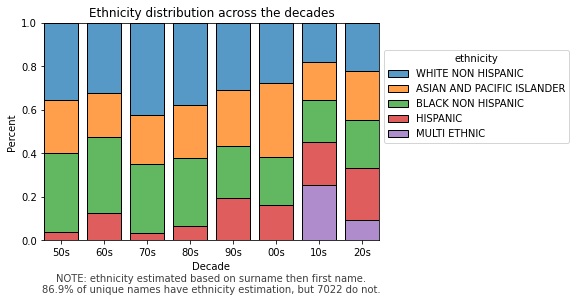

In [55]:
ax = sns.histplot(x='decades', data=temp_df, hue='ethnicity', 
             stat='percent',shrink = 0.8, common_norm=False,
             multiple='fill'
            )
sns.move_legend(ax, bbox_to_anchor=(1,0.9),loc='upper left')
row1 = f'NOTE: ethnicity estimated based on surname then first name.'
row2 = f'{((53450-7022)/53450) * 100:.1f}% of unique names have ethnicity estimation, but 7022 do not.'
add_subtext_to_plot(row1, ax, -0.2)
add_subtext_to_plot(row2, ax, -0.25)
plt.title("Ethnicity distribution across the decades")
plt.xlabel("Decade")

In [56]:
temp_df

,id,name,decades,ethnicity,title,role
0,ts300399,NaN,40s,NaN,Five Came Back: The Reference Films,NaN
1,tm84618,Robert De Niro,70s,WHITE NON HISPANIC,Taxi Driver,ACTOR
2,tm84618,Jodie Foster,70s,WHITE NON HISPANIC,Taxi Driver,ACTOR
3,tm84618,Albert Brooks,70s,WHITE NON HISPANIC,Taxi Driver,ACTOR
4,tm84618,Harvey Keitel,70s,WHITE NON HISPANIC,Taxi Driver,ACTOR
...,...,...,...,...,...,...
77580,tm1098060,Lucien Morgan,20s,WHITE NON HISPANIC,Shadow Parties,ACTOR
77581,tm1098060,Magdalena Korpas,20s,HISPANIC,Shadow Parties,ACTOR
77582,tm1098060,Mistura Olusanya,20s,NaN,Shadow Parties,ACTOR
77583,tm1098060,Yemi Amodu,20s,NaN,Shadow Parties,DIRECTOR


Text(0.5, 1.0, 'Employee ethnicity in films industry based on Netflix catalogue')

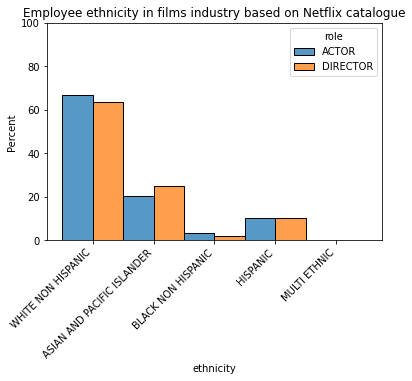

In [57]:
sns.histplot(x='ethnicity', data=temp_df, stat='percent',hue='role', multiple='dodge', common_norm=False)
plt.ylim(0,100)
plt.xticks(horizontalalignment='right', rotation=45)
plt.title('Employee ethnicity in films industry based on Netflix catalogue')

# NLP

In [58]:
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

In [59]:
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('spacytextblob')

def get_sentiment_score(text):
    '''
    Uses spacy to get the sentiment score of a blob of text
    '''
    if type(text) != str:
        return text
    
    doc = nlp(text)
    sentiment = doc._.blob.polarity
    
    return sentiment

In [60]:
def label_sentiment_score(score):
    if score > 0:
        return 'positive'
    elif score < 0:
        return 'negative'
    else:
        return 'neutral'

In [ ]:
combined['sentiment_score'] = combined['description'].apply(get_sentiment_score)
combined['sentiment'] = combined['sentiment_score'].apply(label_sentiment_score)

In [ ]:
combined.groupby('release_year').mean().reset_index().plot('release_year','sentiment_score')
plt.title("Sentiment score of descriptions over the years")

In [ ]:
combined['decades'] = pd.cut(
    x=combined['release_year'],
    bins=[1940,1950,1960,1970,1980,1990,2000,2010,2020,2030],
    labels=['40s','50s','60s','70s','80s','90s','00s','10s','20s']
)

In [ ]:
grpd_plt = combined.groupby('decades').count().reset_index()

In [ ]:
sns.catplot(x='decades', y='title', data=grpd_plt, kind='point')
plt.title('Number of motion pictures from each decade')


In [ ]:
sns.catplot(x='decades', y='sentiment_score', data=combined, kind='strip')
plt.title('Distribution of description sentiment scores')

In [ ]:
combined['sentiment_score_t'] = combined['title'].apply(get_sentiment_score)
combined['sentiment_t'] = combined['sentiment_score_t'].apply(label_sentiment_score)

In [ ]:
combined.groupby('release_year').mean().reset_index().plot('release_year','sentiment_score_t')
plt.title("Sentiment scores of titles over the years")

In [ ]:
sns.catplot(x='decades', y='sentiment_score_t', data=combined, kind='strip')
plt.title('Distribution of title sentiment scores')

In [ ]:
combined.corr()

In [ ]:
combined.plot(x='release_year',y='imdb_score', kind='scatter')
plt.title('Netflix catalogue kept highly rated old films, but all new films')

In [ ]:
combined.plot(x='imdb_score', y='tmdb_score', kind='scatter')
plt.title('IMDB and TMDB scores are highly correlated (r2 = 0.59)')

In [ ]:
score = len(combined.dropna(subset=['tmdb_score', 'imdb_score']))
print(f"{score} movies have both a TMDB and an IMDB score")

score = combined[combined['imdb_score'].isna()]['tmdb_score'].isna().sum()
print(f"{score} movies have no TMDB score or IMDB score")

score = combined[~combined['imdb_score'].isna()]['tmdb_score'].isna().sum()
print(f"{score} movies have a TMDB score but no IMDB score")

score = combined[~combined['tmdb_score'].isna()]['imdb_score'].isna().sum()
print(f"{score} movies have an IMDB score but no TMDB score")

In [ ]:
combined['potential_seasons'] = 2022 - combined['release_year']

In [ ]:
def cat_pot_seasons(pot_ses):
    if pot_ses < 5:
        return '< 5'
    elif (pot_ses>=5) & (pot_ses<=10):
        return '5-10'
    else:
        return '> 10'

In [ ]:
combined['potential_seasons_cat'] = combined['potential_seasons'].apply(cat_pot_seasons)

In [ ]:
combined['potential_seasons_left'] = combined['potential_seasons'] - combined['seasons']

In [ ]:
sns.scatterplot(x='release_year',y='potential_seasons_left', data=combined, hue='type')
plt.title('The number of seasons per show decreases the newer the show is')

In [ ]:
sns.scatterplot(x='runtime', y='seasons', data=combined,hue='type')

In [ ]:
sns.scatterplot(x='runtime', y='imdb_score', data=combined,hue='type')

In [ ]:
age_label = {
    'G': 0,
    'PG': 8,
    'PG-13': 13,
    'R': 17,
    'NC-17': 18,
    'TV-Y': 0,
    'TV-Y7': 7,
    'TV-G': 0,
    'TV-PG': 8,
    'TV-14': 14,
    'TV-MA': 17
}

In [ ]:
combined['recommended_min_age_viewership'] = combined['age_certification'].map(age_label)

In [ ]:
sns.catplot(x='recommended_min_age_viewership', data=combined, kind='count')

In [ ]:
combined['type_dummy'] = pd.get_dummies(combined['type'])['MOVIE']

In [ ]:
combined['age_certification'] = combined['age_certification'].fillna(0)
combined['seasons'] = combined['seasons'].fillna(0)

In [ ]:
combined

# Spacy Tutorial

Source: https://realpython.com/natural-language-processing-spacy-python/

In [ ]:
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

In [ ]:
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('spacytextblob')
introduction_text = ('This tutorial is about Natural Language Processing in Spacy.')
intro_doc = nlp(introduction_text)

In [ ]:
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

In [ ]:
for token in intro_doc:
    if not token.is_stop:
        print(token)

Lemmatization is the process of reducing inflected forms of a word while still ensuring that the reduced form belongs to the language. This reduced form or root word is called a lemma.

In [ ]:
for token in intro_doc:
    print(token, token.lemma_)

In [ ]:
complete_text = nlp('Gus Proto is a Python developer currently'
...     ' working for a London-based Fintech company. He did not work at kent state univeristy He is'
...     ' interested in learning Natural Language Processing.'
...     ' There is a developer conference happening on 21 July'
...     ' 2019 in London. It is titled "Applications of Natural'
...     ' Language Processing". There is a helpline number '
...     ' available at +1-1234567891. Gus is helping organize it.'
...     ' He keeps organizing local Python meetups and several'
...     ' internal talks at his workplace. Gus is also presenting'
...     ' a talk. The talk will introduce the reader about "Use'
...     ' cases of Natural Language Processing in Fintech".'
...     ' Apart from his work, he is very passionate about music.'
...     ' Gus is learning to play the Piano. He has enrolled '
...     ' himself in the weekend batch of Great Piano Academy.'
...     ' Great Piano Academy is situated in Mayfair or the City'
...     ' of London and has world-class piano instructors.')

In [ ]:
complete_text

In [ ]:
# remove stop words and puctuation
words = [token.lemma_ for token in complete_text if not token.is_stop and not token.is_punct]
words.sort()

In [ ]:
from collections import Counter

In [ ]:
# I think this uses the lemmas of words to count freq
word_freq = Counter(words)

In [ ]:
word_freq.most_common(5)

## Part of Speech Tagging

In [ ]:
nouns = []
adjectives = []

for token in complete_text:
    if token.pos_ == 'NOUN':
        nouns.append(token)
    if token.pos_ == 'ADJ':
        adjectives.append(token)

In [ ]:
adjectives[0].lemma_

In [ ]:
len(nouns) + len(adjectives)

## Visualization

In [ ]:
from spacy import displacy

In [ ]:
displacy.render(complete_text, style='dep', jupyter=True)

In [ ]:
def is_token_allowed(token):
    '''
    Only allow valid tokens that are not stop words or
    punctuation symbols
    '''
    if (not token or not token.text.strip() or token.is_stop or token.is_punct):
        return False
    return True

def preprocess_token(token):
    '''
    Reduce token to its lowercase lemma form
    '''
    return token.lemma_.strip().lower()

complete_filtered_tokens = [preprocess_token(token) for token in complete_text if is_token_allowed(token)]

## Sentiment Analysis

In [ ]:
sentiment = complete_text._.blob.polarity
sentiment = round(sentiment,2)

In [ ]:
sentiment

In [ ]:
positive_words = []
negative_words = []
neutral_words = []

for x in complete_text._.blob.sentiment_assessments.assessments:
  if x[1] > 0:
    positive_words.append(x[0][0])
  elif x[1] < 0:
    negative_words.append(x[0][0])
  else:
    neutral_words.append(x)

In [ ]:
positive_words

In [ ]:
negative_words

In [ ]:
len(positive_words) + len(negative_words) + len(neutral_words)